# Gillespie algorithm

The Gillespie algorithm simulates the solution of reactions that described by systems of equations of the form

$$
\dfrac{d X_i}{dt} = \sum_j R_{ij}(X,t)
$$

with $R_{ij}$ various "production" or "decay" rates.

The idea is illustrated in this example:

Let's say that we have a number of particles that can populate two states $x$ and $y$. Assume that the exchange of populations is described by 

\begin{align}
\dfrac{dx}{dt} &= \alpha y - \gamma x\\
\dfrac{dy}{dt} &= \gamma x - \alpha y
\end{align}

The rates here are equal for simplicity, but they do not have to be if the particles can just go outside of the system (maybe there exists another state that can be occupied).

The idea now is to take assign a transition probabilities:

\begin{align}
P(x \to y) &= \dfrac{\gamma x}{\gamma x+\alpha y} \\
P(y \to x) &= \dfrac{\alpha y}{\gamma x+\alpha y}
\end{align}

Then, we can take discrete time-steps. In each step, we will change the populations according to the transition probabilities. 

The crucial point is that each time-step will correspond to **only one** event. The time that an event happens is itself a random variable with a mean time given by $\delta t \sim \dfrac{1}{\gamma x + \alpha y}$. The process of an event happening is a Poisson process, which means that the time it takes for a process to happen is distributed exponentially. See [Stochastic Simulation of Chemical Kinetics](https://www.annualreviews.org/doi/pdf/10.1146/annurev.physchem.58.032806.104637) for a good explanation!

# Application to SIR

The evolution of the various compartments in the SIR model is described by 

\begin{align}
    \frac{dS}{dt} & = -\lambda S +r R\\
    \frac{dI}{dt} & = \lambda S - \gamma I \\
    \frac{dR}{dt} & = \gamma I -r R
\end{align}


with $\lambda = \beta \ \dfrac{I}{N}$ (a simple case). 


The Gillespie Algorithm can be applied here by noting that the rates are

\begin{align}
    R_{S \to I} &= \lambda S \\
    R_{I \to R} &=\gamma I \\
    R_{R \to S} &=r R \\
\end{align}


In [1]:
import numpy as np
import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from scipy.integrate import Radau

# The algorithm for this example

In [2]:
N=1e4
I0=10


beta=1/4
gamma=1/10
r=1/120

S=[N-I0]
I=[I0]
R=[0]
t=[0]
tend=30*12*2

while t[-1]<=tend and I[-1]!=0:
    
    #current values of S, I, and R
    S_prev=S[-1]
    I_prev=I[-1]
    R_prev=R[-1]
    
    #lambda
    lam = beta*I_prev/(S_prev+I_prev+R_prev)
    
    #sum of rates
    sum_rates = lam*S_prev+gamma*I_prev+r*R_prev
    
    #current transition probabilities
    p_SI=lam*S_prev/sum_rates
    p_IR=gamma*I_prev/sum_rates
    p_RS=r*R_prev/sum_rates
    
    #a random "local" time step
    #it is a random time that one transition can happen.
    #Note that the "total" transition time is 1/(total transition rate)
    tau=np.random.exponential(scale=1/sum_rates)

    t_next=t[-1]+tau
    t.append(t_next)
    
    S_next = S_prev
    I_next = I_prev
    R_next = R_prev
    
    
    # Basically, you draw from a multinomial with probabilities (p_SI,p_IR)
    # taht is, you draw a number from the uniform. 
    # If this number is smaller than p_SI, then the event that corresponds to
    # this time step is S->I. 
    # If the number is between p_SI and p_SI+P_IR (=1 in this case), the
    # event that corresponds to t is I->R.
    
    #draw random numbers and check what transitions happen
    _r=np.random.uniform(0,1)
    
    #this produces one I and removes one S
    if _r<=p_SI:
        S_next -= 1
        I_next += 1
    
    #this removes one I and produces one R
    if _r>p_SI and _r<=p_SI+p_IR:
        I_next -= 1
        R_next += 1

    #this removes one R and produces one S
    if _r>p_SI+p_IR and _r<=p_SI+p_IR+p_RS:
        R_next -= 1
        S_next += 1

    S.append(S_next)
    I.append(I_next)
    R.append(R_next)

t=np.array(t)    
S=np.array(S)    
I=np.array(I)    
R=np.array(R)

In [3]:
def system(t,X,beta,gamma,r):
    S=X[0]
    I=X[1]
    R=X[2]
    
    lam = beta*I/(S+I+R)
    
    dSdt=-lam*S+r*R
    dIdt=lam*S-gamma*I
    dRdt=gamma*I-r*R
    
    
    return [dSdt,dIdt,dRdt]

In [4]:
evolution = Radau(fun=lambda t,X: system(t,X,beta,gamma,r),t0=t[0],y0=[S[0],I[0],R[0]],t_bound=tend)

In [5]:
solution=[[evolution.t,*evolution.y]]
while evolution.status == 'running':
    evolution.step()
    solution.append([evolution.t,*evolution.y])

solution=np.array(solution)

<IPython.core.display.Javascript object>


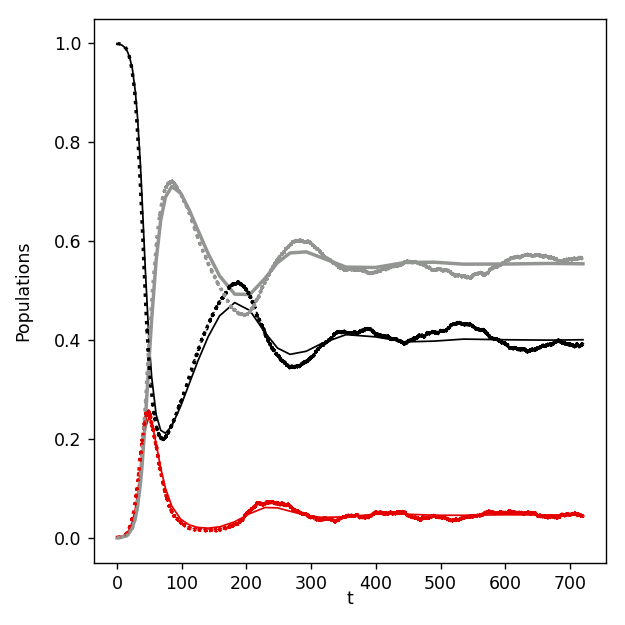

In [6]:
fig=plt.figure(figsize=(5,5))
fig.subplots_adjust(bottom=0.1, left=0.15, top = 0.97, right=0.97)
sub = fig.add_subplot(111)

sub.plot(solution[:,0],solution[:,1]/N,color='xkcd:black',linewidth=1)
sub.plot(solution[:,0],solution[:,2]/N,color='xkcd:red',linewidth=1)
sub.plot(solution[:,0],solution[:,3]/N,color='xkcd:gray',linewidth=2)

# sub.scatter(t,S/N,color='xkcd:black',marker='+',s=2)
# sub.scatter(t,I/N,color='xkcd:red',marker='+',s=2)
# sub.scatter(t,R/N,color='xkcd:gray',marker='+',s=2)

sub.plot(t,S/N,color='xkcd:black',linestyle=':',linewidth=2)
sub.plot(t,I/N,color='xkcd:red',linestyle=':',linewidth=2)
sub.plot(t,R/N,color='xkcd:gray',linestyle=':',linewidth=2)


sub.set_xlabel('t')
sub.set_ylabel('Populations')
sub.yaxis.set_label_coords(-0.12, 0.5)
sub.xaxis.set_label_coords(0.5, -0.05)
plt.show()